In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal, stats
from sklearn import linear_model
import sys
import warnings; warnings.filterwarnings("ignore")

from aux import get_seg
from disp import set_font_size
from my_stats import nanpearsonr

cc = np.concatenate

FPS_DN = 8.5  # sampling rate from neural data
DT_DN = 1/FPS_DN
NT_H_DN = 85
T_H_DN = np.arange(NT_H_DN)*DT_DN

FPS = 30.03
DT = 1/FPS
NT_H = int(round(NT_H_DN*FPS/FPS_DN))
T_H = np.arange(NT_H)*DT

H_S_COLS = [f'IT_H_S_{it}' for it in range(NT_H_DN)]
H_P_COLS = [f'IT_H_P_{it}' for it in range(NT_H_DN)]

SAVE_DIR_LIN = 'data/simple/mlv_c/neur_basic/c_pacheco_lin'
PFX_LIN = 'mlv_c_pacheco_lin'

SAVE_DIR_DYN = 'data/simple/mlv_c/neur_basic/c_pacheco_dyn'
PFX_DYN = 'mlv_c_pacheco_dyn'

if not os.path.exists(SAVE_DIR_LIN):
    os.makedirs(SAVE_DIR_LIN)
if not os.path.exists(SAVE_DIR_DYN):
    os.makedirs(SAVE_DIR_DYN)

Load behavioral data from Coen et al 2014

In [2]:
df_behav = pd.read_csv('data/simple/c_song_f_behav.csv')
df_behav

,ID,FRAME,T,Q,S,P,F,FFV,FFA,FLS,FRS
0,0,0,0.000000,1,0,0,0,0.231,0.0000,0.159,0.077
1,0,1,0.033300,1,0,0,0,0.314,0.0385,0.025,0.044
2,0,2,0.066600,1,0,0,0,0.308,0.0025,0.029,0.011
3,0,3,0.099900,1,0,0,0,0.319,0.0020,0.016,0.016
4,0,4,0.133200,1,0,0,0,0.312,-0.0315,0.030,0.002
...,...,...,...,...,...,...,...,...,...,...,...
4978565,275,27100,902.430902,1,0,0,0,0.217,0.0280,0.029,0.058
4978566,275,27101,902.464202,1,0,0,0,0.210,-0.1045,0.138,0.322
4978567,275,27102,902.497502,1,0,0,0,0.008,-0.0910,0.034,0.260
4978568,275,27103,902.530803,1,0,0,0,0.028,0.0695,0.010,0.090


In [3]:
# split big df into dfs for individual trials
n_tr = np.max(df_behav.ID) + 1
dfs_tr = [df_behav[df_behav.ID == i] for i in range(n_tr)]

tr_lens = np.array([len(df_tr) for df_tr in dfs_tr])
tr_lens_cum = cc([[0], np.cumsum(tr_lens)])

n_t_total = np.sum(tr_lens)
assert n_t_total == tr_lens_cum[-1]
df_behav = None

# Linear neural responses

Load params from linear fits on Baker et al data.

In [4]:
# neural response fits from Baker data
df_lin_param = pd.read_csv('data/simple/neur/pacheco_lin_fit_param.csv')
df_lin_param

,EXPT_ID,LINE,FLY,ROI,ROI_USED,FIT_ERR,SUCCESS,IDUR_H,T_0,R_0,...,IT_H_P_75,IT_H_P_76,IT_H_P_77,IT_H_P_78,IT_H_P_79,IT_H_P_80,IT_H_P_81,IT_H_P_82,IT_H_P_83,IT_H_P_84
0,0,R70G01,0,somas,False,0.530906,True,85,0,-0.006939,...,-0.339622,0.561031,0.009952,-0.019431,-0.010408,-0.348939,0.098820,-0.067707,0.048094,0.123893
1,1,R70G01,1,somas,False,0.355251,True,85,0,-0.002337,...,0.388769,-0.426401,0.329820,-0.889790,0.263947,-0.513387,0.949490,-0.270495,0.477949,1.561191
2,2,R70G01,2,somas,False,0.747824,True,85,0,-0.004365,...,0.024309,-0.572662,0.111280,0.474526,-0.790019,0.826221,-0.672372,0.100478,0.029410,0.381562
3,3,R70G01,3,somas,False,0.739510,True,85,0,-0.001410,...,-0.168137,-2.539934,1.934715,1.123649,-1.900755,1.060162,-0.556732,-0.412909,-1.551010,0.274843
4,4,R70G01,4,somas,False,0.570795,True,85,0,-0.003073,...,-0.042762,-0.148701,0.601252,-0.571722,-0.356380,-0.090784,-0.615883,0.048584,0.209703,0.546290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,219,VT34811,0,somas,False,0.332961,True,85,0,0.005917,...,-0.581794,-0.527614,1.340811,2.288938,-1.423614,-0.402030,-1.389864,0.272802,-1.099182,1.262069
220,220,VT34811,0,ascending projection,False,0.081183,True,85,0,0.001794,...,0.114481,-0.000353,-0.036719,-0.039764,0.049547,0.064971,-0.068562,0.044180,-0.058720,-0.787796
221,221,vPN1_split,0,somas,False,1.003179,True,85,0,0.006406,...,1.288491,0.560029,-1.601996,-1.187890,-1.658313,-1.325864,-0.523994,2.632098,-0.771290,0.509721
222,222,vPN1_split,1,somas,False,1.304569,True,85,0,-0.011839,...,-0.579526,-11.263469,11.736080,1.971183,-5.754064,-2.208219,7.978729,-6.847465,1.874838,-8.842646


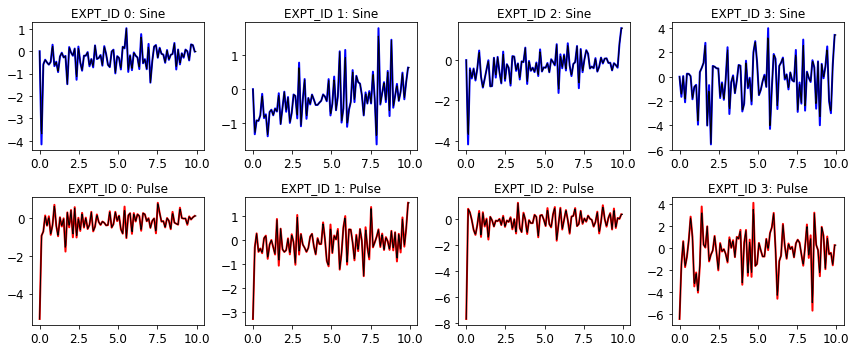

In [5]:
expt_ids = df_lin_param['EXPT_ID']

# extract filters (downsampled)
hs_dn_s = np.array([df_lin_param[expt_ids == expt_id].iloc[0][H_S_COLS] for expt_id in expt_ids]).astype(float)
hs_dn_p = np.array([df_lin_param[expt_ids == expt_id].iloc[0][H_P_COLS] for expt_id in expt_ids]).astype(float)

# upsample filters via interpolation
hs_s = np.array([np.interp(T_H, T_H_DN, h_dn_s) for h_dn_s in hs_dn_s])
hs_p = np.array([np.interp(T_H, T_H_DN, h_dn_p) for h_dn_p in hs_dn_p])

fig, axs = plt.subplots(2, 4, figsize=(12, 5), tight_layout=True)
for cexpt, ax_col in enumerate(axs.T):
    ax_col[0].plot(T_H_DN, hs_dn_s[cexpt], c='b', lw=2)
    ax_col[0].plot(T_H, hs_s[cexpt], c='k', lw=1)
    ax_col[0].set_title(f'EXPT_ID {expt_ids[cexpt]}: Sine')
    
    ax_col[1].plot(T_H_DN, hs_dn_p[cexpt], c='r', lw=2)
    ax_col[1].plot(T_H, hs_p[cexpt], c='k', lw=1)
    ax_col[1].set_title(f'EXPT_ID {expt_ids[cexpt]}: Pulse')
    
set_font_size(axs, 12)

Neural responses are given by convolution of each neuron's impulse response with song

$$r(t) = h_{sine}(t) \circledast I_{sine}(t) + h_{pulse}(t) \circledast I_{pulse}(t) = \int_0^{\infty} h_{sine}(t') I_{sine}(t-t')dt' + \int_0^{\infty} h_{pulse}(t') I_{pulse}(t-t')dt'$$

In [6]:
# compute surrogate linear neural responses for each trial
for ctr, df_tr in enumerate(dfs_tr):
    df_tr_nrl_lin = df_tr.copy()
    sys.stdout.write('.')
    # loop over neurons
    for expt_id, h_s, h_p in zip(expt_ids, hs_s, hs_p):
        # compute surrogate neural response
        i_s = np.array(df_tr['S']).astype(float)
        i_p = np.array(df_tr['P'] | df_tr['F']).astype(float)
        
        r = signal.fftconvolve(i_s, h_s, mode='full')[:len(i_s)] \
            + signal.fftconvolve(i_p, h_p, mode='full')[:len(i_p)]
        
        df_tr_nrl_lin[f'R_{expt_id}'] = r
        
    np.save(os.path.join(SAVE_DIR_LIN, f'{PFX_LIN}_tr_{ctr}.npy'), np.array([{'df': df_tr_nrl_lin}]))

....................................................................................................................................................................................................................................................................................

# Dynamical systems neural responses

Load params from dynamical systems fits to Baker et al data

In [7]:
# neural response fits from Baker data
df_dyn_param = pd.read_csv('data/simple/neur/pacheco_dyn_fit_param.csv')
df_dyn_param

,EXPT_ID,LINE,FLY,ROI,ROI_USED,FIT_ERR,SUCCESS,T_0,R_0,TAU_R,TAU_A,X_S,X_P
0,0,R70G01,0,somas,False,0.275200,True,-0.000000,0.028882,6.202615,30.336758,-4.958290,-2.597432
1,1,R70G01,1,somas,False,0.186212,True,0.117647,0.025128,3.835468,21.821295,-4.163967,-1.472075
2,2,R70G01,2,somas,False,0.248414,True,-0.000000,0.055962,6.017162,15.058055,-6.248007,-2.095952
3,3,R70G01,3,somas,False,0.455963,True,-0.000000,-0.014227,6.016828,11.820576,-5.679735,-2.118245
4,4,R70G01,4,somas,False,0.229018,True,-0.000000,0.019831,6.434825,55.496220,-4.415761,-2.863647
...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,219,VT34811,0,somas,False,0.276087,True,-0.000000,0.039119,1.799608,1440.994269,-0.049828,2.494657
220,220,VT34811,0,ascending projection,False,0.037801,True,-0.000000,-0.001886,1.298841,27.643238,0.098451,2.457383
221,221,vPN1_split,0,somas,False,0.404112,True,-0.588235,-0.014702,4.151226,6.155551,8.332263,2.353217
222,222,vPN1_split,1,somas,False,1.205977,True,0.235294,-0.095665,5.924070,90.705238,2.390705,0.604586


In [8]:
expt_ids = df_dyn_param['EXPT_ID']

# get parameters
tau_rs = np.array(df_dyn_param['TAU_R'])
tau_as = np.array(df_dyn_param['TAU_A'])
x_ss = np.array(df_dyn_param['X_S'])
x_ps = np.array(df_dyn_param['X_P'])

In [9]:
# define smln & obj function
def smlt(i_s, i_p, tau_r, tau_a, x_s, x_p):
    """Simulate response to song inputs."""
    t = np.arange(len(i_s))*DT
    r = np.nan*np.zeros(len(t))
    
    r[0] = 0
    a_s, a_p = 0, 0
    
    for ct, t_ in enumerate(t[1:], 1):
        a_s += ((DT/tau_a) * (-a_s + x_s*i_s[ct]))
        a_p += ((DT/tau_a) * (-a_p + x_p*i_p[ct]))
        r[ct] = r[ct-1] + (DT/tau_r) * (-r[ct-1] + (x_s - a_s)*i_s[ct] + (x_p - a_p)*i_p[ct])
    
    return r

In [ ]:
# compute surrogate linear neural responses for each trial
for ctr, df_tr in enumerate(dfs_tr):
    df_tr_nrl_dyn = df_tr.copy()
    sys.stdout.write('.')
    # loop over neurons
    for expt_id, tau_r, tau_a, x_s, x_p in zip(expt_ids, tau_rs, tau_as, x_ss, x_ps):
        # compute surrogate neural response
        i_s = np.array(df_tr['S']).astype(float)
        i_p = np.array(df_tr['P'] | df_tr['F']).astype(float)
        
        r = smlt(i_s, i_p, tau_r, tau_a, x_s, x_p)
        
        df_tr_nrl_dyn[f'R_{expt_id}'] = r
        
    np.save(os.path.join(SAVE_DIR_DYN, f'{PFX_DYN}_tr_{ctr}.npy'), np.array([{'df': df_tr_nrl_dyn}]))

.